> **Overview** <br/>
LLM + RAG 기법을 활용하여, Chatbot의 질문에 대한 답의 성능을 높이기 위해 Langchain을 활용하여 HANA Cloud의 데이터 컨텍스트를 반영하는 방법을 진행한다.

In [1]:
import pandas as pd
import json
import os
import hana_ml
from hana_ml import ConnectionContext

print(pd.__version__)
print(hana_ml.__version__)

2.2.0
2.19.24022101


C:\Users\CESCO\AppData\Local\Temp\ipykernel_88004\2357728272.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 2.HANA Cloud DB 연결

In [2]:
#Connect HANA Table
with open(os.path.join(os.getcwd(), 'E:\Enablement-hands-on\HANA-configure-teon.json')) as f:
    hana_env_c = json.load(f)
    port_c = hana_env_c['port']
    user_c = hana_env_c['user']
    host_c = hana_env_c['host']
    pwd_c = hana_env_c['pwd']

cc = ConnectionContext(address=host_c, port=port_c, user=user_c, password=pwd_c, encrypt=True)
cursor = cc.connection.cursor()
cursor.execute("""SET SCHEMA GEN_AI""")

#Check hana_ml version
print(cc.hana_version())
#Check current schema
print(cc.get_current_schema())

4.00.000.00.1713874676 (CE2024.14)
GEN_AI


## 3.Vector Embedding

In [3]:
#get embedding
from gen_ai_hub.proxy.native.openai import embeddings

def get_embedding(input, model="dc872f9eef04c31a") -> str:
    response = embeddings.create(
        deployment_id = model,
        input = input
    )
    return response.data[0].embedding

## 4.HANA Vector Search 함수 생성
SAP HANA에서 HANA 벡터 검색을 함수로 생성할 예정이다.<br/>
아래에서는 HANA 데이터베이스에서 Python 코드와 SQL 쿼리를 통합하여 벡터 검색을 수행하는 방법에 대한 자세한 튜토리얼을 제공하고 있다.<br/>
이 튜토리얼은 텍스트 데이터를 통한 임베딩과 유사 벡터 검색을 사용하여 SAP HANA의 기능을 활용하는 방법을 이해하는데 도움이 될 것이다.

### 1) Vector search 함수 생성
제공된 Python 함수 `run_vector_search_kr` 및 `run_vector_search_en`은 텍스트 데이터를 기반으로 가장 유사한 항목을 찾기 위해 벡터 검색 기술을 사용하여 HANA 데이터베이스를 쿼리하도록 설계되었다.

**사용된 주요 매개 변수:**
- `query`: 검색할 입력 문자열
- `metric`: 벡터 비교에 사용되는 거리 측정 기준 정의(COSINE_SIMILARITY OR L2DISTANCE).
- `k`: 반환할 상위 결과의 수 지정

**함수 구성 요소:**
- `메트릭 및 정렬 로직`: 선택된 메트릭(CONSINE_SIMILARITY 또는 L2DISTANCE)에 따라 정렬 순서와 컬럼 이름(COS_SIM 또는 L2D_SIM)이 선택된다.
    - `COSINE_SIMILARITY`의 경우 높은 값이 가까운 벡터를 나타내므로 `DESC` (-1 ~ 1)
    - `L2DISTANCE`의 경우 작은 값이 가까운 벡터를 나타내므로 `ASC`
- `쿼리 벡터 생성`: 함수 `get_embedding(query)`는 입력 쿼리를 텍스트 임베딩을 사용하여 벡터로 변환한다.
- `sql 쿼리 구성`: SQL 쿼리는 유사성 또는 거리 메트릭을 기반으로 상위 k결과를 검색한다.

In [4]:
# Wrapping HANA vector search in a function - 한국어
def run_vector_search_kr(query: str, metric="COSINE_SIMILARITY", k=5):
    if metric == 'L2DISTANCE':
        sort = 'ASC'
        col = 'L2D_SIM'
    elif metric == 'COSINE_SIMILARITY':
        sort = 'DESC'
        col = 'COS_SIM'
    query_vector = get_embedding(query)
    sql = '''SELECT TOP {k} "BlockID","MaterialNumber", "MaterialName",
    "MaterialDescription_KR","PurchasingGroupDescription_KR", "Blocked_stock",
    "Block_reason_KR","Blocked_date", "Solution_KR", "Solution_date", 
    "{metric}"("VECTOR_KR", TO_REAL_VECTOR('{qv}'))
    AS "{col}"
    FROM "DEMO_BLOCK_TEON"
    ORDER BY "{col}" {sort}
    '''.format(k=k, metric = metric, qv = query_vector, sort=sort, col=col)
    hdf = cc.sql(sql)
    df_context = hdf.collect()
    return df_context

# Wrapping HANA vector search in a function - 영어
def run_vector_search_en(query: str, metric="COSINE_SIMILARITY", k=5):
    if metric == 'L2DISTANCE':
        sort = 'ASC'
        col = 'L2D_SIM'
    elif metric == 'COSINE_SIMILARITY':
        sort = 'DESC'
        col = 'COS_SIM'
    query_vector = get_embedding(query)
    sql = '''SELECT TOP {k} "BlockID","MaterialNumber", "MaterialName",
    "MaterialDescription","PurchasingGroupDescription", "Blocked_stock",
    "Block_reason","Blocked_date", "Solution", "Solution_date", 
    "{metric}"("VECTOR_EN", TO_REAL_VECTOR('{qv}'))
    AS "{col}"
    FROM "DEMO_BLOCK_TEON"
    ORDER BY "{col}" {sort}
    '''.format(k=k, metric = metric, qv = query_vector, sort=sort, col=col)
    hdf = cc.sql(sql)
    df_context = hdf.collect()
    return df_context

### 2) Vector search 테스트(영어)

In [5]:
#Test the vector search
query = "What is the quality issue for packing defects for cabinet?"
df_context_en = run_vector_search_en(query=query, metric="COSINE_SIMILARITY", k=5)
df_context_en

,BlockID,MaterialNumber,MaterialName,MaterialDescription,PurchasingGroupDescription,Blocked_stock,Block_reason,Blocked_date,Solution,Solution_date,COS_SIM
0,2,250249,VITTSJ√ñ,"Laptop stand, 35x65 cm",Tables & desks,34657,Identification of packaging defects that compr...,2024-03-10,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...",2024-04-23,0.808054
1,10,69276256,M√ñCKELBY / HENRIKSDAL,"Table and 6 chairs, 235x100 cm",Tables & desks,3051,Identification of packaging defects that compr...,2024-06-06,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...",2024-09-03,0.798295
2,4,39213915,KLIMPEN,"Table, 150x75 cm",Tables & desks,21111,Critical feedback on packaging quality leading...,2024-06-20,"[{""Instruction_step"": 1, ""Instruction"": ""Gathe...",2024-06-27,0.796200
3,5,50391421,NORDLI,"Top and plinth, 40x47 cm",Chests of drawers & drawer units,23208,Discrepancies in item quantity received by cus...,2024-05-06,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...",2024-05-08,0.778709
4,7,29203889,PLATSA,"Wardrobe, 140x57x261 cm",Wardrobes,14629,Experiencing supplier delays that result in in...,2024-03-19,"[{""Instruction_step"": 1, ""Instruction"": ""Ident...",2024-07-07,0.772991


In [6]:
#Test the vector search
query = "What is the quality issue for packing defects for cabinet?"
df_context_en2 = run_vector_search_en(query=query, metric="L2DISTANCE", k=5)
df_context_en2

,BlockID,MaterialNumber,MaterialName,MaterialDescription,PurchasingGroupDescription,Blocked_stock,Block_reason,Blocked_date,Solution,Solution_date,L2D_SIM
0,2,250249,VITTSJ√ñ,"Laptop stand, 35x65 cm",Tables & desks,34657,Identification of packaging defects that compr...,2024-03-10,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...",2024-04-23,0.619591
1,10,69276256,M√ñCKELBY / HENRIKSDAL,"Table and 6 chairs, 235x100 cm",Tables & desks,3051,Identification of packaging defects that compr...,2024-06-06,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...",2024-09-03,0.635145
2,4,39213915,KLIMPEN,"Table, 150x75 cm",Tables & desks,21111,Critical feedback on packaging quality leading...,2024-06-20,"[{""Instruction_step"": 1, ""Instruction"": ""Gathe...",2024-06-27,0.638435
3,5,50391421,NORDLI,"Top and plinth, 40x47 cm",Chests of drawers & drawer units,23208,Discrepancies in item quantity received by cus...,2024-05-06,"[{""Instruction_step"": 1, ""Instruction"": ""Condu...",2024-05-08,0.665268
4,7,29203889,PLATSA,"Wardrobe, 140x57x261 cm",Wardrobes,14629,Experiencing supplier delays that result in in...,2024-03-19,"[{""Instruction_step"": 1, ""Instruction"": ""Ident...",2024-07-07,0.673808


### 3) Vector search 테스트(한글)

In [7]:
#Test the vector search
query = "의자의 포장불량에 대한 문제는 무엇입니까?"
df_context_kr = run_vector_search_kr(query=query, metric="COSINE_SIMILARITY", k=5)
df_context_kr

,BlockID,MaterialNumber,MaterialName,MaterialDescription_KR,PurchasingGroupDescription_KR,Blocked_stock,Block_reason_KR,Blocked_date,Solution_KR,Solution_date,COS_SIM
0,10,69276256,M√ñCKELBY / HENRIKSDAL,"테이블과 6개의 의자, 235x100 cm",테이블 & 책상,3051,출하 전에 제품의 무결성을 저해하는 포장 결함을 식별하여 즉각적인 수정 조치가 필요...,2024-06-06,"[{""Instruction_step"": 1, ""Instruction_KR"": ""현재...",2024-09-03,0.805098
1,1,59829111,PO√ÑNG,발판,소파 & 안락의자,2695,안전 문제로 특정 제품 배치에 대한 긴급 리콜이 발생하여 소비자의 안전을 보장합니다.,2024-01-20,"[{""Instruction_step"": 1, ""Instruction_KR"": ""영향...",2024-01-31,0.797426
2,2,250249,VITTSJ√ñ,"노트북 스탠드, 35x65 cm",테이블 & 책상,34657,출하 전에 제품의 무결성을 저해하는 포장 결함을 식별하여 즉각적인 시정 조치가 필요...,2024-03-10,"[{""Instruction_step"": 1, ""Instruction_KR"": ""현재...",2024-04-23,0.796537
3,4,39213915,KLIMPEN,"테이블, 150x75 cm",테이블 & 책상,21111,포장 품질에 대한 중요한 피드백이 포장 재료와 과정의 검토로 이어집니다.,2024-06-20,"[{""Instruction_step"": 1, ""Instruction_KR"": ""중요...",2024-06-27,0.788745
4,6,80369112,NORDVIKEN,"등받이가 있는 바 의자, 75 cm",의자들,1200,고객이 받은 품목 수량의 불일치로 인해 불만과 주문 정정 요청이 발생합니다.,2024-05-23,"[{""Instruction_step"": 1, ""Instruction_KR"": ""주문...",2024-07-13,0.788112


In [37]:
#Test the vector search
query = "의자의 포장불량에 대한 문제는 무엇입니까?"
df_context_kr2= run_vector_search_kr(query=query, metric="L2DISTANCE", k=5)
df_context_kr2

,BlockID,MaterialNumber,MaterialName,MaterialDescription_KR,PurchasingGroupDescription_KR,Blocked_stock,Block_reason_KR,Blocked_date,Solution_KR,Solution_date,L2D_SIM
0,10,69276256,M√ñCKELBY / HENRIKSDAL,"테이블과 6개의 의자, 235x100 cm",테이블 & 책상,3051,출하 전에 제품의 무결성을 저해하는 포장 결함을 식별하여 즉각적인 수정 조치가 필요...,2024-06-06,"[{""Instruction_step"": 1, ""Instruction_KR"": ""현재...",2024-09-03,0.624342
1,1,59829111,PO√ÑNG,발판,소파 & 안락의자,2695,안전 문제로 특정 제품 배치에 대한 긴급 리콜이 발생하여 소비자의 안전을 보장합니다.,2024-01-20,"[{""Instruction_step"": 1, ""Instruction_KR"": ""영향...",2024-01-31,0.636512
2,2,250249,VITTSJ√ñ,"노트북 스탠드, 35x65 cm",테이블 & 책상,34657,출하 전에 제품의 무결성을 저해하는 포장 결함을 식별하여 즉각적인 시정 조치가 필요...,2024-03-10,"[{""Instruction_step"": 1, ""Instruction_KR"": ""현재...",2024-04-23,0.637907
3,4,39213915,KLIMPEN,"테이블, 150x75 cm",테이블 & 책상,21111,포장 품질에 대한 중요한 피드백이 포장 재료와 과정의 검토로 이어집니다.,2024-06-20,"[{""Instruction_step"": 1, ""Instruction_KR"": ""중요...",2024-06-27,0.650008
4,6,80369112,NORDVIKEN,"등받이가 있는 바 의자, 75 cm",의자들,1200,고객이 받은 품목 수량의 불일치로 인해 불만과 주문 정정 요청이 발생합니다.,2024-05-23,"[{""Instruction_step"": 1, ""Instruction_KR"": ""주문...",2024-07-13,0.650981


## 5.LangChain
해당 단계에서는 LangChain을 사용하여 block된 재고에 대한 대화형 챗봇을 구현합니다.<br/>
이 예제에서는 Prompt Template과 검색 증강 생성(Retrieval Augmented Generation, RAG) 기술을 활용하여 질문에 대한 답변을 생성합니다.

### 1) Prompt Template 생성
Prompt Template에서 창고 관리를 지원하는 도우미로서의 역할을 하는 데 필요한 정보를 제공하는 prmpt template을 생성합니다. 이 템플릿은 질문에 대한 맥락을 제공하고, 답변의 출력 형식을 맞추도록 요청합니다.
- `promptTemplate_fstring`: 영어 사용자를 위한 프롬프트 템플릿
- `promptTemplate_fstring_kr`: 한국어 사용자를 위한 프롬프트 템플릿

In [68]:
promptTemplate_fstring = """
You are provided multiple context items that are related to the prompt
you have to answer.
Use the following pieces of context to answer the question at the end.
Context:
{context}
Question:
{query}
Answer:
To answer questions, Please provides solutions with detail instructions
with steps and ResponsibleDepartment.
You must format your output as a json that adheres in english.
This is example format:
1. Solution:
- Responsible department:
- Instructions:
1) , 2) , 3), ...
2. Solution:
- Responsible department:
- Instructions:
1) , 2) , 3), ...
...
"""

promptTemplate_fstring_KR = """
You are provided multiple context items that are related to the prompt
you have to answer.
Use the following pieces of context to answer the question at the end.
Context:
{context}
Question:
{query}
Answer:
To answer questions, Please provides Solution_KR with detail instructions
with steps and ResponsibleDepartment_KR for each step.
You must format your output as a plain text adheres in korean.
This is example format:
1. 해결방안:
- 담당부서:
- 해결절차:
1) , 2) , 3), ...
2. 해결방안:
- 담당부서:
- 해결절차:
1) , 2) , 3), ...
...
"""

### 2) LLM 기반의 RAG Chatbot 생성
RAG 기법을 사용하여 HANA 벡터 검색을 통해 얻은 맥락 정보를 기반으로 자연어 처리 모델(Large Language Model, LLM)을 사용해 질문에 답변한다.

**전체 프로세스**
1. **프롬프트 템플릿 준비**: 사용자의 입력(질문)과 관련 맥락을 포함하는 프롬프트를 준비한다.
2. **맥락 정보 수집**: 필요한 경우 HANA 벡터 검색을 통해 관련 맥락 정보를 수집한다.
3. **LLM을 통한 답변 생성**: 수집된 맥락 정보를 포함한 프롬프트를 LLM에 제공하고, 모델이 질문에 답변하도록 한다.
4. **답변 출력**: 모델의 답변을 사용자에게 제공한다.

**코드 설명**
- `langchain`, `gen_ai_hub.proxy.langchain.openai`, `gen_ai.hub.proxy.core.proxy.clients`: 이 모듈들은 LangChain 기능을 통합하고, OpenAI의 챗봇 API를 사용할 수 있게 해준다.
- `promptTemplate`: `PromptTemplate.from_template() 메서드를 사용해 프롬프트 템플릿을 초기화한다.
- `ask_llm_en`: 이 함수는 영어 질문을 처리하며, RAG 여부에 따라 동작이 달라진다.
    - `RAG=True`: `run_vector_search_en` 함수를 호출하여 관련 문서를 검색하고, 검색된 문서의 정보를 바탕으로 프롬프트를 구성한다.
    - `RAG=False`: 맥락 정보 없이 질문만을 기반으로 프롬프트 생성한다.
- `LLM 호출`: ChatOpenAI 클래스를 사용하여 구성된 프롬프트로 챗봇을 호출하고, 결과를 출력한다.
- `Deployment_id`: GenAI Hub에 deploy된 모델을 사용한다.

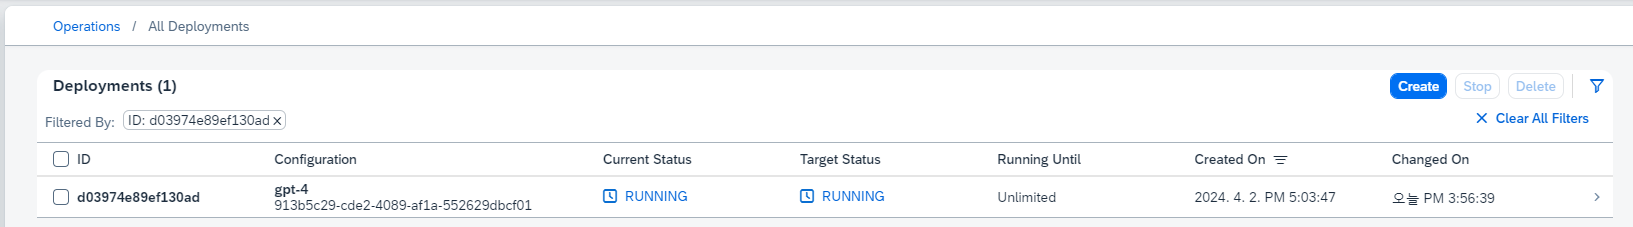

In [69]:
from langchain import PromptTemplate
from gen_ai_hub.proxy.langchain.openai import ChatOpenAI
from gen_ai_hub.proxy.core.proxy_clients import get_proxy_client
proxy_client = get_proxy_client('gen-ai-hub')

promptTemplate = PromptTemplate.from_template(promptTemplate_fstring)
promptTemplate2 = PromptTemplate.from_template(promptTemplate_fstring_KR)

def ask_llm_en(query: str, retrieval_augmented_generation: bool, metric='L2DISTANCE', k=5) -> str:
    class color:
        RED = '\033[91m' #ANSI 이스케이프 시퀀스
        BLUE = '\033[94m'
        BOLD = '\033[1m'
        END = '\033[0m'
    context = ''
    if retrieval_augmented_generation == True:
        df_context = run_vector_search_en(query, metric, k)
        #print(color.RED + '\nHANA vector search returned {k} best matching documents.'.format(k=k) + color.END)
        #print(color.RED + '\nGenerating LLM prompt using the context information.' + color.END)
        print(df_context)
    else:
        print(color.RED + 'Generating LLM prompt WITHOUT context information.' + color.END)
    
    prompt = promptTemplate.format(query=query, 
                                   context=''.join(df_context[["BlockID", "MaterialNumber",
                                                                "MaterialName", "MaterialDescription",
                                                                "PurchasingGroupDescription",
                                                                "Block_reason", "Blocked_date",
                                                                "Solution", "Solution_date"]].astype('string')))
    
    print(color.RED + '\nAsking LLM...' + color.END)

    llm = ChatOpenAI(deployment_id="d03974e89ef130ad", temperature=0)
    response = llm.predict(prompt)

    print(response)

def ask_llm_kr(query: str, retrieval_augmented_generation: bool, metric='L2DISTANCE', k=5) -> str:
    class color:
        RED = '\033[91m' #ANSI 이스케이프 시퀀스
        BLUE = '\033[94m'
        BOLD = '\033[1m'
        END = '\033[0m'
    context = ''
    if retrieval_augmented_generation == True:
        df_context = run_vector_search_kr(query, metric, k)
        #print(color.RED + '\nHANA vector search returned {k} best matching documents.'.format(k=k) + color.END)
        #print(color.RED + '\nGenerating LLM prompt using the context information.' + color.END)
        print(df_context)
    else:
        print(color.RED + 'Generating LLM prompt WITHOUT context information.' + color.END)
    
    prompt = promptTemplate2.format(query=query, 
                                   context=''.join(df_context[["BlockID", "MaterialNumber",
                                                                "MaterialName", "MaterialDescription_KR",
                                                                "PurchasingGroupDescription_KR",
                                                                "Block_reason_KR", "Blocked_date",
                                                                "Solution_KR", "Solution_date"]].astype('string')))
    
    print(color.RED + '\nAsking LLM...' + color.END)

    llm = ChatOpenAI(deployment_id="d03974e89ef130ad", temperature=0)
    response = llm.predict(prompt)

    print(response)

## 6.테스트
해당 단계에서는 설정한 챗봇을 통해 실제 질문에 대한 답변을 얻는 테스트 과정을 설명한다. 여기에는 한국어 질문과 영어 질문이 포함되며, 각각의 질문에 대한 함수 호출을 통해 답변을 확인한다.

### 1) 질문하고 답변 얻기
검색 증강 생성(RAG) 기능을 사용하여 ask_llm_kr와 ask_llm_en 함수를 호출한다.<br/>
이 함수들은 HANA 벡터 검색을 통해 관련 맥락 정보를 수집하고, 이 정보를 바탕으로 LLM이 질문에 대한 답변을 생성하도록 함.

In [70]:
#query = "가구 포장 불량 배송에 대한 해결방안은 무엇인가요?"
query = "의자의 포장불량에 대한 문제는 무엇입니까?"
response = ask_llm_kr(query=query, retrieval_augmented_generation=True, k=5)
print(response)

   BlockID  MaterialNumber            MaterialName   MaterialDescription_KR  \
0       10        69276256  M√ñCKELBY / HENRIKSDAL  테이블과 6개의 의자, 235x100 cm   
1        1        59829111                  PO√ÑNG                       발판   
2        2          250249                VITTSJ√ñ        노트북 스탠드, 35x65 cm   
3        4        39213915                 KLIMPEN           테이블, 150x75 cm   
4        6        80369112               NORDVIKEN      등받이가 있는 바 의자, 75 cm   

  PurchasingGroupDescription_KR  Blocked_stock  \
0                      테이블 & 책상           3051   
1                     소파 & 안락의자           2695   
2                      테이블 & 책상          34657   
3                      테이블 & 책상          21111   
4                           의자들           1200   

                                     Block_reason_KR Blocked_date  \
0  출하 전에 제품의 무결성을 저해하는 포장 결함을 식별하여 즉각적인 수정 조치가 필요...   2024-06-06   
1    안전 문제로 특정 제품 배치에 대한 긴급 리콜이 발생하여 소비자의 안전을 보장합니다.   2024-01-20   
2  출하 전에 제품의 무결성을

In [71]:
query2 = "What can be solution for the dlivery for packing defects for furniture"
response2 = ask_llm_en(query=query2, retrieval_augmented_generation=True, k=5)
print(response2)

   BlockID  MaterialNumber            MaterialName  \
0        2          250249                VITTSJ√ñ   
1       10        69276256  M√ñCKELBY / HENRIKSDAL   
2        4        39213915                 KLIMPEN   
3        7        29203889                  PLATSA   
4        3        10364523               KALLVIKEN   

               MaterialDescription PurchasingGroupDescription  Blocked_stock  \
0          Laptop stand,  35x65 cm             Tables & desks          34657   
1  Table and 6 chairs,  235x100 cm             Tables & desks           3051   
2                Table,  150x75 cm             Tables & desks          21111   
3         Wardrobe,  140x57x261 cm                  Wardrobes          14629   
4                  Door,  60x64 cm       TV & media furniture           2262   

                                        Block_reason Blocked_date  \
0  Identification of packaging defects that compr...   2024-03-10   
1  Identification of packaging defects that compr...   2